In [197]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [198]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

In [199]:
#from symmetry_model import ScNN

In [244]:
#dfine a sampling subclass of Layer
#the Sampling layer takes two inputs: mean and log_sigma
#the layer samples random samples from mean and log_sigma assuming that the mean and log_sigma are from from a gaussian distribution
class Sampling(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        #unpack the inputs
        mean, log_var = inputs
        batch_size = tf.shape(mean)[0]
        #size of the latent layer
        units = tf.shape(mean)[1]
        #generate random samples from a gaussian distribution of mean=0 and standard deviation=1
        epsilon = tf.random.normal(shape=(batch_size, units), mean=0, stddev=1)
        #shift and scale epsilon
        return mean + tf.math.exp(log_var/2)*epsilon

class Encoder(keras.layers.Layer):
    def __init__(self, latent_size=1, layer_size=[70, 70], activation='elu', **kwargs):
        super().__init__(**kwargs)
        self.layer_size = layer_size
        self.latent_size = latent_size
        self.encoder_layer = []
        for i in range(len(self.layer_size)):
            self.encoder_layer.append(Dense(layer_size[i], activation=activation, name=('encoder_layer'+str(i+1))))
        self.z = Dense(latent_size, activation=activation, name='latent_layer')
        
    def call(self, inputs):
        x = inputs
        for i in range(len(self.layer_size)):
            x = self.encoder_layer[i](x)
        z = self.z(x)
        return z

class DifferenceSquared(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        input1 = inputs[0]
        input2 = inputs[1]
        mean_squared = tf.reshape(tf.reduce_sum((input1 - input2)**2, axis=1), (-1,1))
        return mean_squared

#create a subclass VAE of Model
#the model takes encoder and decoder models and joins them to build beta-VAE
#the model defines a training method to train the beta-VAE model so constructed
"""Variables in the class object:

   encoder               --   encoder model to produce mean and log_var as output from the input
   decoder               --   decoder model to produce the output
   reconstruction_loss   --   total loss for the output accuracy of the decoder - sum over total outputs and average over samples
   kl_loss               --   total loss for the kl-metric - sum over output units of latent layer and average over samples
   total_loss            --   reconstruction_loss + kl_loss
   beta_rec              --   parameter to control the relative significance of reconstruction loss
   beta_kl               --   parameter to control the relative significance of kl-divergence loss
"""

class ScNN(Model):
    def __init__(self, input_size=50, encoder_layer=[70, 70], latent_size=1, output_size=1, beta_rec=500., activation='elu', **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(layer_size=encoder_layer, latent_size=latent_size, activation=activation, name='encoder')
        self.difference_squared = DifferenceSquared(name='comparison_layer')
        self.output_classify = Dense(output_size, activation='sigmoid', name='output')
        self.beta_rec = beta_rec
        #define the losses
        #Mean stores the mean value of the argument passed to it and a name for the mean value
        self.bce = keras.losses.BinaryCrossentropy(from_logits=False)
        self.total_loss = keras.metrics.Mean(name='total_loss')
        self.total_reconstruction_loss = keras.metrics.Mean(name='reconstruction_loss')
    #return the losses to be printed during training
    def build(self, input_shape):
        # Add any operations you need to perform during build, like creating weights.
        super().build(input_shape)
    @property
    def metrics(self):
        return [self.total_loss, self.total_reconstruction_loss]
    #feeds an output of encoder and question to the decoder and returns the outputs of encoder and decoder
    #encoder input and a question is passed as input
    def call(self, inputs):
        input1 = inputs[:,0:4]
        input2 = inputs[:,4:8]
        z1 = self.encoder(input1)
        z2 = self.encoder(input2)
        decoder_output = self.difference_squared([z1, z2])
        
        output = self.output_classify(decoder_output)
        return output
    #training method called when called to fit
    #the method is passed a set of observation, a question for each observation and the corresponding answers
    def train_step(self, data):
        inputs = data['input']
        outputs = data['output']
        
        with tf.GradientTape() as tape:
            #feed-forward step
            #calls the call() method
            predictions = self(inputs)
            #calculate losses for the current feed-forward step
            #outputs and predictions are one dimensional so only take mean over samples
            #reconstruction_loss = self.beta_rec*tf.reduce_mean(tf.reduce_sum((outputs - predictions)**2, axis=1))
            reconstruction_loss = self.beta_rec*self.bce(outputs, predictions)
            #take sum over dimension and mean over samples
            #kl_loss = 0.5*self.beta_kl*tf.reduce_mean(tf.reduce_sum(tf.square(z_mean) + 2*tf.exp(z_log_sigma) -  2*z_log_sigma, axis=1))
            loss = reconstruction_loss
            #calculates gradients w.r.t. the trainable weights of the model
            gradients = tape.gradient(loss, self.trainable_weights)
            #updates the trainable weights using the gradients calculated
            #method to update the weights is passed in call to compile function of the model as optimizer parameter
            self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
            #updates the current losses
            self.total_reconstruction_loss.update_state(reconstruction_loss)
            self.total_loss.update_state(loss)
            #return the losses name and the corresponding values
            return {m.name: m.result() for m in self.metrics}

# Data Generation

In [201]:
def generate3DRotations(num=1):
    vector_dimension = 4
    random_3drotation = np.zeros((num, vector_dimension, vector_dimension))
    random_3drotation[:, 1:,1:] = scipy.spatial.transform.Rotation.random(train_samples).as_matrix()
    random_3drotation[:,0,0] = 1
    return random_3drotation

In [208]:
def generateLorentzTransforms(num=1):
    vector_dimension = 4
    beta = np.random.uniform(low=0, high=0.99, size=(train_samples, 1,1))
    gamma = 1/np.sqrt(1-beta**2)
    random_lorentz_trans = np.zeros((train_samples, vector_dimension, vector_dimension))
    random_lorentz_trans[:, 0:1, 1] = beta[:,0:1,0]
    random_lorentz_trans[:, 1:2, 0] = beta[:,0:1,0]
    random_lorentz_trans[:, 0, 0] = 1
    random_lorentz_trans[:, 1, 1] = 1
    random_lorentz_trans = random_lorentz_trans*gamma
    random_lorentz_trans[:, 2, 2] = 1
    random_lorentz_trans[:, 3, 3] = 1
    return random_lorentz_trans

In [209]:
def calculateInterval(event):
    vector_dimension = event.shape[1]
    interval = event[:,0:1]**2
    for i in range(1, vector_dimension):
        interval -= event[:,i:i+1]**2
    return interval

In [210]:
train_samples = 50000
vector_dimension = 4

random_3drotation1 = generate3DRotations(num=train_samples)
random_3drotation2 = generate3DRotations(num=train_samples)

random_lorentz_trans = generateLorentzTransforms(num=train_samples)

In [211]:
random_lorentz_trans = np.matmul(np.matmul(random_3drotation1, random_lorentz_trans), random_3drotation2)

In [212]:
events_train = np.random.uniform(low=-1, high=1, size=(train_samples, vector_dimension, 1))
events_similar_train = np.matmul(random_lorentz_trans, events_train)

#the third index does not store any extra dimension
events_train = events_train[:,:,0]
events_similar_train = events_similar_train[:,:,0]

rng = np.random.default_rng()
events_asimilar_train = rng.permutation(events_similar_train, axis=1)

In [213]:
events_train = np.row_stack((events_train, events_train))
print('events_train.shape: '+str(events_train.shape))

transformed_events = np.row_stack((events_similar_train, events_asimilar_train))
print('transformed_events.shape: '+str(transformed_events.shape))

true_label = np.zeros((train_samples,1))
false_label = np.ones((train_samples,1))
labels = np.row_stack((true_label, false_label))
print('labels.shape: '+str(labels.shape))

event_pairs_and_similar_label = np.column_stack((events_train, transformed_events, labels))
event_pairs_and_similar_label = rng.permutation(event_pairs_and_similar_label, axis=0)

events_train.shape: (100000, 4)
transformed_events.shape: (100000, 4)
labels.shape: (100000, 1)


In [231]:
interval1 = calculateInterval(event_pairs_and_similar_label[:,:4])
interval2 = calculateInterval(event_pairs_and_similar_label[:,4:8])

In [232]:
print(interval1[:20].T)
print(interval2[:20].T)
print(event_pairs_and_similar_label[:20,-1])

[[-0.70676288 -0.85369407 -0.17025569 -0.80262543 -0.97369181 -0.15977353
  -0.84187347 -0.85602873 -1.0418498  -0.11697056 -0.43526787 -0.55669337
  -1.29500094 -1.22813809 -0.93855722 -0.99593009  0.66204229 -0.61555704
   0.23628257 -0.87764698]]
[[ 0.04318917 -0.96906135 -0.45494832 -0.80262543 -0.97369181 -0.15977353
   0.77589974 -0.85602873 -1.34542064 -0.11697056 -0.24783517 -0.55669337
  -1.29500094 -1.22813809 -6.30546965 -0.99593009 -1.97414375 -0.61555704
  -2.60386625 -0.87764698]]
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]


# Model Training

In [257]:
#input_size=50, encoder_layer=[70, 70], latent_size=3, output_size=1, beta_rec=500., beta_kl=1.
beta_rec = 500

model = ScNN(input_size=8, encoder_layer=[150,150], latent_size=1, output_size=1, beta_rec=beta_rec)

In [258]:
epochs = 50
batch_size = 500
learning_rate = 100.

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
model.fit({'input': event_pairs_and_similar_label[:, :-1], 'output': event_pairs_and_similar_label[:,-1].reshape(-1,1)}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - reconstruction_loss: 4615801490450153472.0000 - total_loss: 4615801490450153472.0000
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - reconstruction_loss: 1268.2445 - total_loss: 1268.2445
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - reconstruction_loss: 1944.7305 - total_loss: 1944.7305
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - reconstruction_loss: 1585.7946 - total_loss: 1585.7946
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - reconstruction_loss: 2534.1201 - total_loss: 2534.1201
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - reconstruction_loss: 1445.7617 - total_loss: 1445.7617
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - reconstruction_loss: 2177.3540 - total_loss: 2177.3540
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - reconstruction_loss: 2376.1306 - total_loss: 2376.1306
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - reconstruction_loss: 712.1015 - total_loss: 

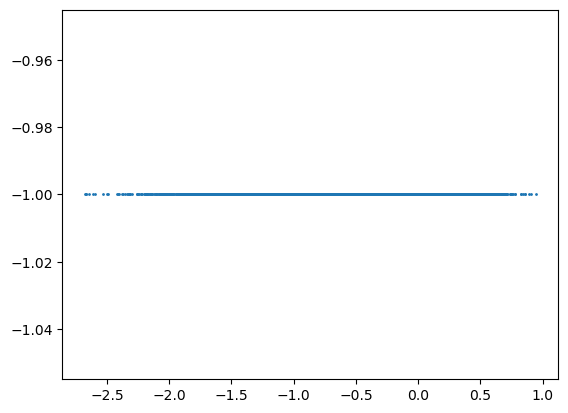

In [259]:
test_samples = 5000
events_test = np.random.uniform(low=-1, high=1, size=(test_samples, vector_dimension))
z = model.encoder(events_test)
interval_test = calculateInterval(events_test)

plt.scatter(interval_test, z, s=1)